# 04 - Dynamic Pricing Optimization with PuLP

**Business Objective**: Maximize annual revenue for a representative Airbnb property by optimizing prices across seasonal and weekend/weekday patterns using production-grade demand forecasting and regime-based price elasticity.

---

## Methodology

This notebook demonstrates a complete pricing optimization workflow:

1. **Load Production Assets**  
   - Pre-trained GBTRegressor model (RMSE=0.0786, R²=0.885) from Notebook 03  
   - Listing-level features with regime-specific elasticity slopes from Notebook 02  
   - Elasticity metadata with price regime breakpoints from Notebook 01

2. **Define Representative Property**  
   - Select ***Paris*** as target market  
   - Create a realistic property profile with market-average features  
   - Use trained ML model to establish baseline prices and occupancy rates for all 6 segments (3 seasons × 2 day types)

3. **Demand Forecasting with Feature Engineering**  
   - Generate candidate prices (simulated range)  
   - Apply regime-specific elasticity slopes (handle breakpoint transitions)  
   - Predict occupancy rate change from specific market's elasticity slope

4. **MILP Optimization with PuLP**  
   - **Objective**: Maximize annual revenue (weighted by days per segment)  
   - **Decision Variables**: Binary selection for each (segment, price) combination  
   - **Constraints**:  
     - One price per segment (mandatory)  
     - Minimum occupancy threshold ≥50% per segment  
     - Weekend premium: weekend price ≥ 1.1 × weekday price (same season)  
     - Portfolio price change limit: ±50% from baseline

5. **Business Insights & Recommendations**  
   - Revenue lift analysis by segment  
   - Price-occupancy tradeoff curves  
   - Seasonal pricing strategy summary  
   - Export optimal pricing schedule for implementation

---

## Key Technical Highlights

✅ **Production ML Integration**: Loads pre-trained Spark MLlib GBTRegressor  
✅ **Regime-Aware Elasticity**: Handles two-regime elasticity with breakpoint transitions  
✅ **Scalable Optimization**: PuLP MILP with realistic business constraints  
✅ **Big Data Practices**: Spark-native processing, converts to Pandas only for optimization  
✅ **Clear Documentation**: Code comments, markdown explanations, and business context

---

## Outputs

- `outputs/optimal_prices_paris.csv`: Optimal pricing schedule with revenue lift  
- `outputs/price_optimization_summary.json`: Business metrics and recommendations  
- `outputs/demand_curves_by_segment.png`: Visualization of price-occupancy relationships

In [ ]:
%load_ext autoreload
%autoreload 2

## Setup & Load Production Assets

In [27]:
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import json
import warnings
warnings.filterwarnings('ignore')

# Locate project root (folder containing 'src')
project_root = Path.cwd()
for p in [project_root] + list(project_root.parents):
    if (p / 'src').exists():
        project_root = p
        break
if not (project_root / 'src').exists():
    raise FileNotFoundError("Could not find 'src' directory.")

# Windows Spark/Hadoop helpers
hadoop_home = project_root / 'hadoop'
bin_dir = hadoop_home / 'bin'
os.environ['HADOOP_HOME'] = str(hadoop_home)
os.environ['hadoop.home.dir'] = str(hadoop_home)
os.environ['PATH'] = str(bin_dir) + os.pathsep + os.environ.get('PATH', '')

sys.path.insert(0, str(project_root))

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.regression import GBTRegressionModel
from pyspark.ml.feature import VectorAssembler

# Initialize Spark
spark = (
    SparkSession.builder
    .appName('airbnb-price-optimization')
    .master('local[*]')
    .config('spark.driver.memory', '4g')
    .config('spark.sql.shuffle.partitions', '32')
    .getOrCreate()
)

print(f"Spark version: {spark.version}")

Spark version: 3.5.0


In [28]:
# Output directory
outputs_dir = project_root / 'outputs'
outputs_dir.mkdir(parents=True, exist_ok=True)

print("Output directory ready")

Output directory ready


In [29]:
# ============================================================================
# LOAD ASSETS
# ============================================================================

print("Loading production assets...\n")

# 1. Load pre-trained GBTRegressor model
model_path = project_root / 'models' / 'spark_MLlib_model'
if not model_path.exists():
    raise FileNotFoundError(f"Model not found: {model_path}. Run Notebook 03 first.")

gbt_model = GBTRegressionModel.load(str(model_path))
print(f"Loaded GBTRegressor model")
print(f"  - Features: {gbt_model.numFeatures}")
print(f"  - Trees: {gbt_model.getNumTrees}")
print(f"  - Performance: RMSE=0.0786, R²=0.885\n")

# 2. Load listing features (with elasticity_slope already joined)
features_path = project_root / 'data' / 'processed' / 'listing_features.parquet'
if not features_path.exists():
    raise FileNotFoundError(f"Features not found: {features_path}. Run Notebook 02 first.")

df = spark.read.parquet(str(features_path))
print(f"Loaded listing features")
print(f"  - Rows: {df.count():,}")
print(f"  - Columns: {len(df.columns)}\n")

# 3. Load elasticity metadata (for breakpoint information)
elasticity_path = project_root / 'outputs' / 'elasticities_by_segment.json'
if not elasticity_path.exists():
    raise FileNotFoundError(f"Elasticity data not found: {elasticity_path}. Run Notebook 01 first.")

with open(elasticity_path, 'r') as f:
    elasticity_metadata = json.load(f)

print(f"Loaded elasticity metadata")
print(f"  - Segments: {len(elasticity_metadata)}")
print(f"  - Format: city_season_season_daytype\n")

print("="*70)
print("ALL PRODUCTION ASSETS LOADED SUCCESSFULLY")
print("="*70)

Loading production assets...

Loaded GBTRegressor model
  - Features: 48
  - Trees: 200
  - Performance: RMSE=0.0786, R²=0.885

Loaded listing features
  - Rows: 305,252
  - Columns: 53

Loaded elasticity metadata
  - Segments: 60
  - Format: city_season_season_daytype

ALL PRODUCTION ASSETS LOADED SUCCESSFULLY


In [30]:
# ============================================================================
# PARSE ELASTICITY METADATA FOR AMSTERDAM
# ============================================================================

print("\nParsing elasticity metadata for Paris...\n")

paris_elasticity = {}

for segment_key, segment_data in elasticity_metadata.items():
    # Parse segment_key format: "{city}_{season}_season_{daytype}"
    # Example: "paris_high_season_weekday"
    
    if not segment_key.startswith('paris_'):
        continue
    
    parts = segment_key.split('_')
    if len(parts) < 4:
        continue
    
    # Extract components
    day_type = parts[-1]  # 'weekday' or 'weekend'
    weekend = 1 if day_type == 'weekend' else 0
    season = parts[-3]  # 'high', 'shoulder', or 'low'
    
    # Extract regime information
    regimes = segment_data.get('regimes', [])
    breakpoint_log_price = segment_data.get('breakpoint_log_price')
    
    if not regimes:
        print(f"  Warning: No regimes found for {segment_key}")
        continue
    
    # Convert log breakpoint to actual price (if two regimes)
    breakpoint_price = None
    if breakpoint_log_price is not None:
        breakpoint_price = np.expm1(breakpoint_log_price)  # Inverse of log1p
    
    # Store in dictionary with (season, weekend) tuple key
    paris_elasticity[(season, weekend)] = {
        'segment_key': segment_key,
        'n_regimes': len(regimes),
        'regimes': regimes,
        'breakpoint_log_price': breakpoint_log_price,
        'breakpoint_price': breakpoint_price
    }
    
    # Print summary
    if len(regimes) == 1:
        print(f"  {segment_key:35s} → 1 regime  | Slope: {regimes[0]['slope']:6.3f}")
    else:
        print(f"  {segment_key:35s} → 2 regimes | Low: {regimes[0]['slope']:6.3f} | High: {regimes[1]['slope']:6.3f} | Breakpoint: ${breakpoint_price:6.2f}")

print(f"\nParsed {len(paris_elasticity)} Paris segments")


Parsing elasticity metadata for Paris...

  paris_high_season_weekday           → 2 regimes | Low:  0.138 | High: -0.623 | Breakpoint: $ 71.51
  paris_high_season_weekend           → 2 regimes | Low:  0.121 | High: -0.479 | Breakpoint: $ 84.63
  paris_shoulder_season_weekday       → 2 regimes | Low:  0.032 | High: -0.835 | Breakpoint: $ 58.49
  paris_shoulder_season_weekend       → 2 regimes | Low:  0.100 | High: -0.716 | Breakpoint: $ 69.37
  paris_low_season_weekday            → 2 regimes | Low: -0.156 | High: -0.953 | Breakpoint: $ 47.83
  paris_low_season_weekend            → 2 regimes | Low:  0.049 | High: -0.802 | Breakpoint: $ 56.51

Parsed 6 Paris segments


## Define Feature Lists

These feature lists must exactly match the order used in Notebook 03 for GBTRegressor training.

In [31]:
# Feature lists (MUST match Notebook 03 training exactly)
numeric_features = [
    'listing_price', 'person_capacity', 'cleanliness_rating',
    'guest_satisfaction_overall', 'bedrooms', 'city_center_dist',
    'metro_dist', 'log_price', 'price_per_person', 'price_per_bedroom',
    'quality_score', 'price_x_satisfaction', 'price_per_dist_km',
    'log_metro_dist', 'segment_avg_price', 'segment_median_price', 
    'segment_p90_price', 'segment_p10_price', 'segment_price_std', 
    'segment_price_spread', 'price_vs_segment_median', 'price_vs_segment_avg', 
    'relative_price_volatility', 'elasticity_slope',
]

binary_features = [
    'host_is_superhost', 'multi', 'biz', 'cat_room_type_entire_home_apt', 
    'cat_room_type_private_room', 'cat_room_type_shared_room', 'cat_city_amsterdam',
    'cat_city_athens', 'cat_city_barcelona', 'cat_city_berlin', 'cat_city_budapest',
    'cat_city_lisbon', 'cat_city_london', 'cat_city_paris', 'cat_city_rome', 
    'cat_city_vienna', 'is_weekend', 'cat_capacity_bin_2', 'cat_capacity_bin_3',
    'cat_capacity_bin_4', 'cat_capacity_bin_5', 'cat_season_high', 'cat_season_low',
    'cat_season_shoulder',
]

all_features = numeric_features + binary_features

# Price-dependent features that must be updated when listing_price changes
price_dependent_features = [
    'log_price', 
    'price_per_person', 
    'price_per_bedroom',
    'price_x_satisfaction', 
    'price_per_dist_km',
    'price_vs_segment_median', 
    'price_vs_segment_avg',
    'relative_price_volatility',     
    'elasticity_slope',
]

print(f"Total features: {len(all_features)}")
print(f"  - Numeric: {len(numeric_features)}")
print(f"  - Binary: {len(binary_features)}")
print(f"  - Price-dependent: {len(price_dependent_features)}")

Total features: 48
  - Numeric: 24
  - Binary: 24
  - Price-dependent: 9


## Define Representative Property Profile

Create a realistic property for Paris with market-average characteristics. This will serve as our optimization target across all seasonal and weekend/weekday segments.

In [32]:
# ============================================================================
# SELECT TARGET CITY AND EXTRACT MARKET STATISTICS
# ============================================================================

TARGET_CITY = 'paris'
print(f"Target city: {TARGET_CITY.upper()}\n")

# Filter Paris listings and compute market averages
paris_df = df.filter(F.col('cat_city_paris') == 1.0)

# Calculate market statistics (median for robustness)
market_stats = paris_df.select(
    F.expr('percentile_approx(listing_price, 0.5)').alias('median_price'),
    F.expr('percentile_approx(person_capacity, 0.5)').alias('median_capacity'),
    F.expr('percentile_approx(bedrooms, 0.5)').alias('median_bedrooms'),
    F.expr('percentile_approx(cleanliness_rating, 0.5)').alias('median_cleanliness'),
    F.expr('percentile_approx(guest_satisfaction_overall, 0.5)').alias('median_satisfaction'),
    F.expr('percentile_approx(city_center_dist, 0.5)').alias('median_city_dist'),
    F.expr('percentile_approx(metro_dist, 0.5)').alias('median_metro_dist'),
).collect()[0]

print("Paris Market Statistics (Median):")
print(f"  Price: $ {market_stats['median_price']:.2f}")
print(f"  Capacity: {market_stats['median_capacity']:.0f} guests")
print(f"  Bedrooms: {market_stats['median_bedrooms']:.0f}")
print(f"  Cleanliness Rating: {market_stats['median_cleanliness']:.1f}/10")
print(f"  Guest Satisfaction: {market_stats['median_satisfaction']:.0f}/100")
print(f"  City Center Distance: {market_stats['median_city_dist']:.2f} km")
print(f"  Metro Distance: {market_stats['median_metro_dist']:.2f} km")

Target city: PARIS

Paris Market Statistics (Median):
  Price: $ 110.11
  Capacity: 2 guests
  Bedrooms: 1
  Cleanliness Rating: 9.0/10
  Guest Satisfaction: 94/100
  City Center Distance: 3.01 km
  Metro Distance: 0.21 km


In [33]:
# ============================================================================
# EXTRACT SEGMENT STATISTICS FOR AMSTERDAM (BY SEASON × WEEKEND)
# ============================================================================

print("Extracting segment statistics for Paris by season × weekend...\n")

# Get segment-level statistics for Paris (group by season and weekend)
segment_stats_list = []

for season in ['high', 'shoulder', 'low']:
    for weekend in [0, 1]:
        # Filter for this specific segment
        if season == 'high':
            segment_filter = (F.col('cat_season_high') == 1.0)
        elif season == 'low':
            segment_filter = (F.col('cat_season_low') == 1.0)
        else:
            segment_filter = (F.col('cat_season_shoulder') == 1.0)
        
        segment_df = paris_df.filter(
            segment_filter & (F.col('is_weekend') == float(weekend))
        )
        
        # Calculate segment statistics
        stats = segment_df.agg(
            F.count('*').alias('listing_price'),
            F.avg('listing_price').alias('segment_avg_price'),
            F.expr('percentile_approx(listing_price, 0.5)').alias('segment_median_price'),
            F.expr('percentile_approx(listing_price, 0.9)').alias('segment_p90_price'),
            F.expr('percentile_approx(listing_price, 0.1)').alias('segment_p10_price'),
            F.stddev('listing_price').alias('segment_price_std'),
            F.avg('days_in_period').alias('avg_days_in_period')
        ).collect()[0]
        
        # Calculate price spread and relative volatility
        segment_price_spread = stats['segment_p90_price'] - stats['segment_p10_price']
        relative_volatility = stats['segment_price_std'] / stats['segment_avg_price'] if stats['segment_avg_price'] > 0 else 0
        
        segment_stats_list.append({
            'season': season,
            'weekend': weekend,
            'is_weekend': float(weekend),
            'cat_season_high': 1.0 if season == 'high' else 0.0,
            'cat_season_low': 1.0 if season == 'low' else 0.0,
            'cat_season_shoulder': 1.0 if season == 'shoulder' else 0.0,
            'segment_avg_price': float(stats['segment_avg_price']),
            'segment_median_price': float(stats['segment_median_price']),
            'segment_p90_price': float(stats['segment_p90_price']),
            'segment_p10_price': float(stats['segment_p10_price']),
            'segment_price_std': float(stats['segment_price_std']),
            'segment_price_spread': float(segment_price_spread),
            'segment_relative_price_volatility': float(relative_volatility),
            'avg_days_in_period': float(stats['avg_days_in_period'])
        })

segment_stats_pd = pd.DataFrame(segment_stats_list)

print("Segment Statistics for Paris (BY SEASON × WEEKEND):")
print(segment_stats_pd[['season', 'weekend', 'segment_avg_price', 
                        'segment_median_price', 'avg_days_in_period']].to_string(index=False))
print()

Extracting segment statistics for Paris by season × weekend...

Segment Statistics for Paris (BY SEASON × WEEKEND):
  season  weekend  segment_avg_price  segment_median_price  avg_days_in_period
    high        0         131.671825            120.730261                87.0
    high        1         154.561946            142.957648                36.0
shoulder        0         108.203904             98.943560               108.0
shoulder        1         127.724341            117.289950                44.0
     low        0          88.701318             80.981454                66.0
     low        1         104.712731             95.774380                24.0



In [34]:
# ============================================================================
# EXTRACT SEGMENT STATISTICS FOR AMSTERDAM (BY SEASON × WEEKEND)
# ============================================================================

print("Extracting segment statistics for Paris by season × weekend...\n")

# Get segment-level statistics for Paris
# Group by season (via cat_season_*) and weekend (is_weekend)
segment_stats_list = []

for season in ['high', 'shoulder', 'low']:
    for weekend in [0, 1]:
        # Filter for this specific segment
        if season == 'high':
            segment_filter = (F.col('cat_season_high') == 1.0)
        elif season == 'low':
            segment_filter = (F.col('cat_season_low') == 1.0)
        else:
            segment_filter = (F.col('cat_season_shoulder') == 1.0)
        
        segment_df = paris_df.filter(
            segment_filter & (F.col('is_weekend') == float(weekend))
        )
        
        # Calculate segment statistics
        stats = segment_df.agg(
            F.count('*').alias('listing_price'),
            F.avg('listing_price').alias('segment_avg_price'),
            F.expr('percentile_approx(listing_price, 0.5)').alias('segment_median_price'),
            F.expr('percentile_approx(listing_price, 0.9)').alias('segment_p90_price'),
            F.expr('percentile_approx(listing_price, 0.1)').alias('segment_p10_price'),
            F.stddev('listing_price').alias('segment_price_std'),
            F.avg('days_in_period').alias('avg_days_in_period')
        ).collect()[0]
        
        # Calculate price spread and relative volatility
        segment_price_spread = stats['segment_p90_price'] - stats['segment_p10_price']
        relative_volatility = stats['segment_price_std'] / stats['segment_avg_price'] if stats['segment_avg_price'] > 0 else 0
        
        segment_stats_list.append({
            'season': season,
            'weekend': weekend,
            'is_weekend': float(weekend),
            'cat_season_high': 1.0 if season == 'high' else 0.0,
            'cat_season_low': 1.0 if season == 'low' else 0.0,
            'cat_season_shoulder': 1.0 if season == 'shoulder' else 0.0,
            'segment_avg_price': float(stats['segment_avg_price']),
            'segment_median_price': float(stats['segment_median_price']),
            'segment_p90_price': float(stats['segment_p90_price']),
            'segment_p10_price': float(stats['segment_p10_price']),
            'segment_price_std': float(stats['segment_price_std']),
            'segment_price_spread': float(segment_price_spread),
            'segment_relative_price_volatility': float(relative_volatility),
            'avg_days_in_period': float(stats['avg_days_in_period'])
        })

segment_stats_pd = pd.DataFrame(segment_stats_list)

print("Segment Statistics for Paris (BY SEASON × WEEKEND):")
print(segment_stats_pd[
    ['season', 'weekend', 'segment_avg_price', 'segment_median_price',
     'segment_p10_price', 'segment_p90_price']
].to_string(
    index=False,
    formatters={
        'segment_avg_price': lambda x: f'{x:.1f}',
        'segment_median_price': lambda x: f'{x:.1f}',
        'segment_p10_price': lambda x: f'{x:.1f}',
        'segment_p90_price': lambda x: f'{x:.1f}',
    }
))
print()

Extracting segment statistics for Paris by season × weekend...

Segment Statistics for Paris (BY SEASON × WEEKEND):
  season  weekend segment_avg_price segment_median_price segment_p10_price segment_p90_price
    high        0             131.7                120.7              63.8             206.5
    high        1             154.6                143.0              75.2             246.6
shoulder        0             108.2                 98.9              52.2             169.3
shoulder        1             127.7                117.3              61.8             200.1
     low        0              88.7                 81.0              42.9             139.1
     low        1             104.7                 95.8              50.4             163.4



In [35]:
# ============================================================================
# CREATE REPRESENTATIVE PROPERTY PROFILE
# ============================================================================

# Base property characteristics (same for all segments)
base_property = {
    # Core characteristics
    'listing_price': market_stats['median_price'],
    'person_capacity': int(market_stats['median_capacity']),
    'bedrooms': int(market_stats['median_bedrooms']),
    'cleanliness_rating': float(market_stats['median_cleanliness']),
    'guest_satisfaction_overall': float(market_stats['median_satisfaction']),
    'city_center_dist': float(market_stats['median_city_dist']),
    'metro_dist': float(market_stats['median_metro_dist']),
    
    # Binary features
    'host_is_superhost': 1,  # Assume superhost
    'multi': 0,  # Single listing
    'biz': 0,  # Not business
    
    # Room type (entire home/apt)
    'cat_room_type_entire_home_apt': 1,
    'cat_room_type_private_room': 0,
    'cat_room_type_shared_room': 0,
    
    # City (Paris)
    'cat_city_paris': 1,
    'cat_city_athens': 0,
    'cat_city_barcelona': 0,
    'cat_city_berlin': 0,
    'cat_city_budapest': 0,
    'cat_city_lisbon': 0,
    'cat_city_amsterdam': 0,
    'cat_city_london': 0,
    'cat_city_rome': 0,
    'cat_city_vienna': 0,
    
    # Capacity bin (based on median capacity)
    'cat_capacity_bin_2': 1 if int(market_stats['median_capacity']) == 2 else 0,
    'cat_capacity_bin_3': 1 if int(market_stats['median_capacity']) == 3 else 0,
    'cat_capacity_bin_4': 1 if int(market_stats['median_capacity']) == 4 else 0,
    'cat_capacity_bin_5': 1 if int(market_stats['median_capacity']) >= 5 else 0,
    
    # Derived features (will be calculated)
    'log_metro_dist': np.log1p(float(market_stats['median_metro_dist'])),
    'quality_score': float(market_stats['median_cleanliness']) * float(market_stats['median_satisfaction']) / 100.0,

}

print("Representative Property Profile (Paris):")
print(f"  Base Price: $ {base_property['listing_price']:.2f}")
print(f"  Capacity: {base_property['person_capacity']} guests")
print(f"  Bedrooms: {base_property['bedrooms']}")
print(f"  Cleanliness: {base_property['cleanliness_rating']:.1f}/10")
print(f"  Satisfaction: {base_property['guest_satisfaction_overall']:.0f}/100")
print(f"  Quality Score: {base_property['quality_score']:.2f}")
print(f"  City Center: {base_property['city_center_dist']:.2f} km")
print(f"  Metro: {base_property['metro_dist']:.2f} km")
print(f"  Superhost: {'Yes' if base_property['host_is_superhost'] else 'No'}")
print(f"  Room Type: Entire Home/Apt")

Representative Property Profile (Paris):
  Base Price: $ 110.11
  Capacity: 2 guests
  Bedrooms: 1
  Cleanliness: 9.0/10
  Satisfaction: 94/100
  Quality Score: 8.46
  City Center: 3.01 km
  Metro: 0.21 km
  Superhost: Yes
  Room Type: Entire Home/Apt


## Helper Functions for Feature Engineering

These functions handle the complex logic of updating price-dependent features and managing regime-based elasticity transitions.

In [36]:
def get_elasticity_slope(price, season, weekend, elasticity_meta):
    """
    Get the appropriate elasticity slope for a given price and segment.
    Handles regime transitions based on breakpoint price.
    
    Args:
        price: Listing price (actual, not log)
        season: Season name ('high', 'shoulder', 'low')
        weekend: 0 for weekday, 1 for weekend
        elasticity_meta: Dictionary with elasticity metadata
    
    Returns:
        float: Elasticity slope for the given price
    """
    meta = elasticity_meta[(season, weekend)]
    regimes = meta['regimes']
    breakpoint_price = meta['breakpoint_price']
    
    # Single regime: return the only slope
    if len(regimes) == 1:
        return regimes[0]['slope']
    
    # Two regimes: select based on price vs breakpoint
    if breakpoint_price is not None:
        if price < breakpoint_price:
            return regimes[0]['slope']  # Lower regime
        else:
            return regimes[1]['slope']  # Upper regime
    
    # Fallback: use first regime
    return regimes[0]['slope']

def update_price_dependent_features(base_dict, new_price, segment_stats, elasticity_meta):
    """
    Create a new feature dictionary with updated price-dependent features.
    
    Updates 9 price-dependent features:
    - listing_price (primary)
    - log_price
    - price_per_person
    - price_per_bedroom
    - price_x_satisfaction
    - price_per_dist_km
    - price_vs_segment_median
    - price_vs_segment_avg
    - relative_price_volatility (from segment stats)
    - elasticity_slope (REGIME-AWARE: changes if price crosses breakpoint)
    
    Args:
        base_dict: Base property feature dictionary
        new_price: New listing price to test
        segment_stats: Dictionary with segment statistics for this (season, weekend) combination
        elasticity_meta: Elasticity metadata dictionary
    
    Returns:
        dict: Updated feature dictionary with all price-dependent features recalculated
    """
    # Create a copy
    updated = base_dict.copy()
    
    # Update primary price
    updated['listing_price'] = float(new_price)
    
    # Update derived price features
    updated["log_price"] = float(np.log1p(new_price))
    updated["price_per_person"] = float(new_price) / max(float(updated.get("person_capacity", 1)), 1.0)
    updated["price_per_bedroom"] = float(new_price) / max(float(updated.get("bedrooms", 1)), 1.0)
    updated["price_x_satisfaction"] = float(new_price) * float(updated.get("guest_satisfaction_overall", 0.0))
    updated["price_per_dist_km"] = float(new_price) / max(float(updated.get("city_center_dist", 0.1)), 0.1)

    # Segment stats (use .get to avoid KeyError)
    segment_median = float(segment_stats.get("segment_median_price", updated.get("segment_median_price", 0.0)) or 0.0)
    segment_avg = float(segment_stats.get("segment_avg_price", updated.get("segment_avg_price", 0.0)) or 0.0)

    updated["price_vs_segment_median"] = (float(new_price) - segment_median) / max(segment_median, 1.0)
    updated["price_vs_segment_avg"] = (float(new_price) - segment_avg) / max(segment_avg, 1.0)

    # Model expects: relative_price_volatility
    updated["relative_price_volatility"] = float(segment_stats.get("segment_relative_price_volatility", 0.0) or 0.0)

    # Regime-aware elasticity
    season = segment_stats.get("season")
    weekend = segment_stats.get("weekend")
    if season is not None and weekend is not None and (season, int(weekend)) in elasticity_meta:
        updated["elasticity_slope"] = float(get_elasticity_slope(float(new_price), season, int(weekend), elasticity_meta))
    else:
        updated["elasticity_slope"] = float(updated.get("elasticity_slope", 0.0) or 0.0)

    return updated

print("Setup complete. Ready for price optimization analysis.")

Setup complete. Ready for price optimization analysis.


## Baseline Prediction: Current Occupancy & Revenue

Predict baseline occupancy for all 6 segments using current market prices. This establishes the performance benchmark we aim to improve.

In [37]:
# ============================================================================
# DEFINE SEGMENTS: 3 seasons × 2 day types = 6 total
# ============================================================================

seasons = ['high', 'shoulder', 'low']
day_types = [0, 1]  # 0 = weekday, 1 = weekend

segments = []
for season in seasons:
    for weekend in day_types:
        segments.append({
            'season': season,
            'weekend': weekend,
            'segment_name': f"{season}_season_{['weekday', 'weekend'][weekend]}"
        })

print(f"Total segments to optimize: {len(segments)}\n")
for seg in segments:
    print(f"  - {seg['segment_name']}")

Total segments to optimize: 6

  - high_season_weekday
  - high_season_weekend
  - shoulder_season_weekday
  - shoulder_season_weekend
  - low_season_weekday
  - low_season_weekend


In [38]:
# ============================================================================
# CALCULATE BASELINE OCCUPANCY AND REVENUE
# ============================================================================

import math

def _safe_float(x, default=0.0) -> float:
    try:
        v = float(x)
    except Exception:
        return float(default)
    return v if math.isfinite(v) else float(default)

def _infer_feature_names_from_vector_metadata(sdf, vector_col: str):
    """Infer ordered input column names from Spark ML vector metadata (ml_attr)."""
    if vector_col not in sdf.columns:
        return None
    meta = sdf.schema[vector_col].metadata or {}
    ml_attr = meta.get("ml_attr", {})
    attrs = ml_attr.get("attrs", {})
    pairs = []
    for _, lst in attrs.items():  # e.g. 'numeric', 'binary', 'nominal'
        for a in lst:
            if "idx" in a and "name" in a:
                pairs.append((int(a["idx"]), str(a["name"])))
    if not pairs:
        return None
    pairs.sort(key=lambda t: t[0])
    return [name for _, name in pairs]

baseline_results = []

print("Predicting baseline occupancy for each segment...\n")

MODEL_FEATURE_COL = gbt_model.getFeaturesCol()
print(f"Model expects featuresCol = '{MODEL_FEATURE_COL}'")
print(f"Model numFeatures = {gbt_model.numFeatures}\n")

# --- Try to auto-align feature order with training metadata (if available) ---
# Prefer the model's featuresCol metadata, then fall back to common names.
inferred = (
    _infer_feature_names_from_vector_metadata(df, MODEL_FEATURE_COL)
    or _infer_feature_names_from_vector_metadata(df, "features")
    or _infer_feature_names_from_vector_metadata(df, "features_unscaled")
)

if inferred:
    print(f"Found {len(inferred)} feature names in df vector metadata")
    if len(inferred) == gbt_model.numFeatures:
        all_features = inferred
        print("Using inferred feature order to match the trained model\n")
    else:
        print(
            f"Metadata feature count ({len(inferred)}) != model.numFeatures ({gbt_model.numFeatures}). "
            "Keeping existing all_features.\n"
        )
else:
    pass

# Hard validation (helps catch silent mismatch early)
if len(all_features) != gbt_model.numFeatures:
    raise ValueError(
        f"Feature length mismatch: len(all_features)={len(all_features)} vs model.numFeatures={gbt_model.numFeatures}. "
        "Your feature list does not match training."
    )


from pyspark.ml.feature import StandardScalerModel

scaler_path = project_root / "models" / "standard_scaler"
if scaler_path.exists():
    scaler_model = StandardScalerModel.load(str(scaler_path))
    print("Loaded StandardScaler from training\n")
    SCALER_INPUT_COL = scaler_model.getInputCol()
    SCALER_OUTPUT_COL = scaler_model.getOutputCol()
else:
    scaler_model = None
    SCALER_INPUT_COL = None
    SCALER_OUTPUT_COL = None

for segment in segments:
    season = segment["season"]
    weekend = segment["weekend"]
    segment_name = segment["segment_name"]

    seg_stats_row = segment_stats_pd[
        (segment_stats_pd["season"] == season) & (segment_stats_pd["weekend"] == weekend)
    ].iloc[0]

    features = base_property.copy()

    # segment flags
    features["is_weekend"] = float(weekend)
    features["cat_season_high"] = 1.0 if season == "high" else 0.0
    features["cat_season_low"] = 1.0 if season == "low" else 0.0
    features["cat_season_shoulder"] = 1.0 if season == "shoulder" else 0.0

    # segment stats (keep, even if not all are in all_features)
    features["segment_avg_price"] = _safe_float(seg_stats_row.get("segment_avg_price", 0.0))
    features["segment_median_price"] = _safe_float(seg_stats_row.get("segment_median_price", 0.0))
    features["segment_p90_price"] = _safe_float(seg_stats_row.get("segment_p90_price", 0.0))
    features["segment_p10_price"] = _safe_float(seg_stats_row.get("segment_p10_price", 0.0))
    features["segment_price_std"] = _safe_float(seg_stats_row.get("segment_price_std", 0.0))
    features["segment_price_spread"] = _safe_float(seg_stats_row.get("segment_price_spread", 0.0))

    baseline_price = _safe_float(seg_stats_row["segment_median_price"])

    seg_stats_dict = seg_stats_row.to_dict()
    features_updated = update_price_dependent_features(
        features,
        baseline_price,
        seg_stats_dict,
        paris_elasticity,
    )

    # If scaler exists, assembler must write to scaler input col; otherwise write to model features col
    vector_out_col = SCALER_INPUT_COL if scaler_model else MODEL_FEATURE_COL

    try:
        # Build a 1-row Spark DF without Python worker serialization
        feature_spark = spark.range(1).select(
            *[
                F.lit(_safe_float(features_updated.get(col, 0.0))).alias(col)
                for col in all_features
            ]
        )

        assembler = VectorAssembler(
            inputCols=all_features,
            outputCol=vector_out_col,
            handleInvalid="keep",
        )
        feature_spark = assembler.transform(feature_spark)

        if scaler_model:
            feature_spark = scaler_model.transform(feature_spark)
            if SCALER_OUTPUT_COL != MODEL_FEATURE_COL:
                feature_spark = feature_spark.withColumnRenamed(SCALER_OUTPUT_COL, MODEL_FEATURE_COL)

        prediction = gbt_model.transform(feature_spark)
        predicted_occupancy = float(prediction.select("prediction").first()["prediction"])
        predicted_occupancy = max(0.0, min(1.0, predicted_occupancy))

    except Exception as e:
        # Extra diagnostics for UDF failures
        bad = {c: features_updated.get(c) for c in all_features if not math.isfinite(_safe_float(features_updated.get(c, 0.0)))}
        print(f"  ERROR predicting {segment_name}: {e}")
        if bad:
            print(f"  Non-finite feature values (sanitized to 0.0): {bad}")
        raise

    baseline_results.append(
        {
            "segment_name": segment_name,
            "season": season,
            "weekend": weekend,
            "baseline_price": baseline_price,
            "baseline_occupancy": predicted_occupancy,
            "elasticity_slope": _safe_float(features_updated.get("elasticity_slope", 0.0)),
            "segment_median_price": _safe_float(seg_stats_row["segment_median_price"]),
            "segment_avg_price": _safe_float(seg_stats_row["segment_avg_price"]),
        }
    )

    print(
        f"{segment_name:25s} | Price: ${baseline_price:6.2f} | "
        f"Occupancy: {predicted_occupancy:5.1%} | Elasticity: {features_updated['elasticity_slope']:6.3f}"
    )

baseline_df = pd.DataFrame(baseline_results)
print(f"\nBaseline predictions complete for {len(baseline_df)} segments")



Predicting baseline occupancy for each segment...

Model expects featuresCol = 'features_unscaled'
Model numFeatures = 48

high_season_weekday       | Price: $120.73 | Occupancy: 86.0% | Elasticity: -0.623
high_season_weekend       | Price: $142.96 | Occupancy: 86.6% | Elasticity: -0.479
shoulder_season_weekday   | Price: $ 98.94 | Occupancy: 75.1% | Elasticity: -0.835
shoulder_season_weekend   | Price: $117.29 | Occupancy: 77.9% | Elasticity: -0.716
low_season_weekday        | Price: $ 80.98 | Occupancy: 57.7% | Elasticity: -0.953
low_season_weekend        | Price: $ 95.77 | Occupancy: 69.5% | Elasticity: -0.802

Baseline predictions complete for 6 segments


## Generate Price Candidates & Predict Demand

For each segment, test different prices (±20% from baseline) and predict occupancy. This creates different scenarios for optimization.

In [39]:
# ============================================================================
# PRICING GRID CONFIG
# ============================================================================

# % range around baseline price to test (±50% by default)
PRICE_RANGE_PCT = 0.50

# number of candidate prices per segment (500 by default)
N_PRICE_POINTS = 500

assert 0 < PRICE_RANGE_PCT < 1, "PRICE_RANGE_PCT should be a fraction like 0.20"
assert int(N_PRICE_POINTS) >= 3, "N_PRICE_POINTS should be >= 3"

print(f"PRICE_RANGE_PCT = ±{PRICE_RANGE_PCT:.0%}")
print(f"N_PRICE_POINTS  = {int(N_PRICE_POINTS)}")

PRICE_RANGE_PCT = ±50%
N_PRICE_POINTS  = 500


In [40]:
# ============================================================================
# GENERATE PRICE CANDIDATES FOR EACH SEGMENT (ELASTICITY-DRIVEN WITH BREAKPOINT HANDLING)
# ============================================================================

def calculate_elasticity_adjusted_occupancy(baseline_price, new_price, baseline_occupancy, season, weekend, elasticity_meta):
    """
    Calculate occupancy change using piecewise elasticity for regime transitions.
    
    If the price change crosses a breakpoint, we split the calculation:
    1. Apply regime_1 elasticity from baseline_price to breakpoint
    2. Apply regime_2 elasticity from breakpoint to new_price
    
    Args:
        baseline_price: Starting price
        new_price: Target price to test
        baseline_occupancy: Baseline occupancy from GBT model
        season: 'high', 'shoulder', or 'low'
        weekend: 0 or 1
        elasticity_meta: Elasticity metadata dictionary
    
    Returns:
        float: Predicted occupancy at new_price
    """
    meta = elasticity_meta[(season, weekend)]
    regimes = meta['regimes']
    breakpoint_price = meta['breakpoint_price']
    
    # CASE 1: Single regime (no breakpoint)
    if len(regimes) == 1:
        elasticity = regimes[0]['slope']
        price_change_pct = (new_price - baseline_price) / baseline_price
        occupancy_change_pct = elasticity * price_change_pct
        predicted_occupancy = baseline_occupancy * (1 + occupancy_change_pct)
        return max(0.0, min(1.0, predicted_occupancy))
    
    # CASE 2: Two regimes (with breakpoint)
    if breakpoint_price is None:
        # Fallback if breakpoint missing
        elasticity = regimes[0]['slope']
        price_change_pct = (new_price - baseline_price) / baseline_price
        occupancy_change_pct = elasticity * price_change_pct
        predicted_occupancy = baseline_occupancy * (1 + occupancy_change_pct)
        return max(0.0, min(1.0, predicted_occupancy))
    
    regime_low_elasticity = regimes[0]['slope']   # Below breakpoint
    regime_high_elasticity = regimes[1]['slope']  # Above breakpoint
    
    # Determine which regime(s) the price change spans
    baseline_in_low = baseline_price < breakpoint_price
    new_in_low = new_price < breakpoint_price
    
    # CASE 2A: Both prices in same regime
    if baseline_in_low == new_in_low:
        elasticity = regime_low_elasticity if baseline_in_low else regime_high_elasticity
        price_change_pct = (new_price - baseline_price) / baseline_price
        occupancy_change_pct = elasticity * price_change_pct
        predicted_occupancy = baseline_occupancy * (1 + occupancy_change_pct)
        return max(0.0, min(1.0, predicted_occupancy))
    
    # CASE 2B: Price change crosses breakpoint (requires piecewise calculation)
    if baseline_in_low and not new_in_low:
        # Moving UP: baseline → breakpoint (regime_low) → new_price (regime_high)
        
        # Step 1: Apply regime_low elasticity from baseline to breakpoint
        price_change_1_pct = (breakpoint_price - baseline_price) / baseline_price
        occupancy_change_1_pct = regime_low_elasticity * price_change_1_pct
        occupancy_at_breakpoint = baseline_occupancy * (1 + occupancy_change_1_pct)
        
        # Step 2: Apply regime_high elasticity from breakpoint to new_price
        price_change_2_pct = (new_price - breakpoint_price) / breakpoint_price
        occupancy_change_2_pct = regime_high_elasticity * price_change_2_pct
        predicted_occupancy = occupancy_at_breakpoint * (1 + occupancy_change_2_pct)
        
    else:
        # Moving DOWN: baseline → breakpoint (regime_high) → new_price (regime_low)
        
        # Step 1: Apply regime_high elasticity from baseline to breakpoint
        price_change_1_pct = (breakpoint_price - baseline_price) / baseline_price
        occupancy_change_1_pct = regime_high_elasticity * price_change_1_pct
        occupancy_at_breakpoint = baseline_occupancy * (1 + occupancy_change_1_pct)
        
        # Step 2: Apply regime_low elasticity from breakpoint to new_price
        price_change_2_pct = (new_price - breakpoint_price) / breakpoint_price
        occupancy_change_2_pct = regime_low_elasticity * price_change_2_pct
        predicted_occupancy = occupancy_at_breakpoint * (1 + occupancy_change_2_pct)
    
    return max(0.0, min(1.0, predicted_occupancy))


MODEL_FEATURE_COL = gbt_model.getFeaturesCol()
vector_out_col = SCALER_INPUT_COL if "scaler_model" in globals() and scaler_model else MODEL_FEATURE_COL

candidate_results = []
candidate_id = 0

print("Using HYBRID approach: ML baseline + piecewise elasticity-driven occupancy changes\n")
print("Handling regime transitions at breakpoints for segments with 2-regime elasticity\n")

for idx, baseline_row in baseline_df.iterrows():
    
    season = baseline_row["season"]
    weekend = baseline_row["weekend"]
    segment_name = baseline_row["segment_name"]
    baseline_price = baseline_row["baseline_price"]
    baseline_occupancy = baseline_row["baseline_occupancy"]  # From GBT model

    min_price = baseline_price * (1 - PRICE_RANGE_PCT)
    max_price = baseline_price * (1 + PRICE_RANGE_PCT)
    price_candidates = np.linspace(min_price, max_price, N_PRICE_POINTS)
    
    # Get elasticity info for this segment
    meta = paris_elasticity[(season, weekend)]
    breakpoint_price = meta.get('breakpoint_price')
    n_regimes = meta['n_regimes']

    print(f"Processing {segment_name}... ", end="")
    if n_regimes == 2 and breakpoint_price:
        print(f"[2 regimes, breakpoint=${breakpoint_price:.2f}] ", end="")

    for price in price_candidates:
        # Use piecewise elasticity calculation
        predicted_occupancy = calculate_elasticity_adjusted_occupancy(
            baseline_price=baseline_price,
            new_price=price,
            baseline_occupancy=baseline_occupancy,
            season=season,
            weekend=weekend,
            elasticity_meta=paris_elasticity
        )
        
        # Get the elasticity slope at the candidate price (for reporting)
        elasticity_slope = get_elasticity_slope(price, season, weekend, paris_elasticity)
        
        daily_revenue = float(price) * predicted_occupancy

        candidate_results.append(
            {
                "candidate_id": candidate_id,
                "segment_name": segment_name,
                "season": season,
                "weekend": weekend,
                "price": float(price),
                "predicted_occupancy": predicted_occupancy,
                "daily_revenue": daily_revenue,
                "elasticity_slope": elasticity_slope,
            }
        )
        candidate_id += 1

    print(f"{N_PRICE_POINTS} candidates")

candidates_df = pd.DataFrame(candidate_results)

print(f"\nGenerated {len(candidates_df)} total candidates using piecewise elasticity")
print("Demand curves now properly handle regime transitions at breakpoints")

Using HYBRID approach: ML baseline + piecewise elasticity-driven occupancy changes

Handling regime transitions at breakpoints for segments with 2-regime elasticity

Processing high_season_weekday... [2 regimes, breakpoint=$71.51] 500 candidates
Processing high_season_weekend... [2 regimes, breakpoint=$84.63] 500 candidates
Processing shoulder_season_weekday... [2 regimes, breakpoint=$58.49] 500 candidates
Processing shoulder_season_weekend... [2 regimes, breakpoint=$69.37] 500 candidates
Processing low_season_weekday... [2 regimes, breakpoint=$47.83] 500 candidates
Processing low_season_weekend... [2 regimes, breakpoint=$56.51] 500 candidates

Generated 3000 total candidates using piecewise elasticity
Demand curves now properly handle regime transitions at breakpoints


## Calculate Days Per Segment (For Annual Revenue)

Use market data to estimate the number of days in each segment over a full year. This weights the optimization objective properly.

In [41]:
# ============================================================================
# CALCULATE DAYS PER SEGMENT FOR ANNUAL REVENUE WEIGHTING
# ============================================================================

# Extract days_in_period from the original dataset for Paris
days_data = paris_df.groupBy('is_weekend', 'cat_season_high', 'cat_season_low', 'cat_season_shoulder').agg(
    F.avg('days_in_period').alias('avg_days')
).toPandas()

# Map to segment format
days_per_segment = {}

for _, row in days_data.iterrows():
    weekend = int(row['is_weekend'])
    if row['cat_season_high'] == 1.0:
        season = 'high'
    elif row['cat_season_low'] == 1.0:
        season = 'low'
    else:
        season = 'shoulder'
    
    segment_name = f"{season}_season_{['weekday', 'weekend'][weekend]}"
    days_per_segment[segment_name] = float(row['avg_days'])

# Fallback: If days_in_period is not available, use typical seasonal distribution
if not days_per_segment:
    print("Warning: days_in_period not found, using typical seasonal distribution\n")
    # Typical distribution: High=4 months, Shoulder=5 months, Low=3 months
    # Weekend = 2/7 of days, Weekday = 5/7 of days
    days_per_segment = {
        'high_weekday': 120 * 5/7,     # ~86 days
        'high_weekend': 120 * 2/7,     # ~34 days
        'shoulder_weekday': 150 * 5/7, # ~107 days
        'shoulder_weekend': 150 * 2/7, # ~43 days
        'low_weekday': 95 * 5/7,       # ~68 days
        'low_weekend': 95 * 2/7,       # ~27 days
    }

# Add to candidates DataFrame
candidates_df['days_in_segment'] = candidates_df['segment_name'].map(days_per_segment)

# Calculate annual revenue for each candidate
candidates_df['annual_revenue'] = candidates_df['daily_revenue'] * candidates_df['days_in_segment']

print("Days per segment (annual):")
for segment_name, days in sorted(days_per_segment.items()):
    print(f"  {segment_name:20s}: {days:6.1f} days")

total_days = sum(days_per_segment.values())
print(f"\nTotal days: {total_days:.0f}")

if abs(total_days - 365) > 10:
    print("  Warning: Total days significantly different from 365")

Days per segment (annual):
  high_season_weekday :   87.0 days
  high_season_weekend :   36.0 days
  low_season_weekday  :   66.0 days
  low_season_weekend  :   24.0 days
  shoulder_season_weekday:  108.0 days
  shoulder_season_weekend:   44.0 days

Total days: 365


## PuLP MILP Optimization

Formulate and solve the optimization problem:
- **Objective**: Maximize annual revenue
- **Variables**: Binary selection for each (segment, price) combination
- **Constraints**: One price per segment, minimum occupancy, weekend premiums, portfolio limits

In [42]:
# Install PuLP if not already installed
try:
    import pulp
    print(f"PuLP version: {pulp.__version__}")
except ImportError:
    print("Please install PuLP to proceed with optimization (e.g., pip install pulp)")

PuLP version: 2.8.0


In [43]:
import pulp

# ============================================================================
# FORMULATE MILP OPTIMIZATION PROBLEM
# ============================================================================

print("Formulating Mixed-Integer Linear Programming optimization problem...\n")

# Create the optimization problem
prob = pulp.LpProblem('AirbnbRevenueOptimization', pulp.LpMaximize)

# Decision variables: binary selection for each candidate
x = {}
for idx, row in candidates_df.iterrows():
    cand_id = int(row['candidate_id'])
    x[cand_id] = pulp.LpVariable(
        f'x_{cand_id}',
        lowBound=0,
        upBound=1,
        cat='Binary'
    )

print(f"Created {len(x)} binary decision variables")

# ============================================================================
# OBJECTIVE FUNCTION: Maximize Annual Revenue
# ============================================================================

prob += pulp.lpSum(
    x[int(row['candidate_id'])] * float(row['annual_revenue'])
    for _, row in candidates_df.iterrows()
), "TotalAnnualRevenue"

print("Objective function: Maximize annual revenue\n")

# ============================================================================
# CONSTRAINTS
# ============================================================================

constraint_count = 0

# 1. ONE PRICE PER SEGMENT (mandatory)
for segment_name in candidates_df['segment_name'].unique():
    segment_candidates = candidates_df[candidates_df['segment_name'] == segment_name]
    prob += (
        pulp.lpSum(
            x[int(row['candidate_id'])] 
            for _, row in segment_candidates.iterrows()
        ) == 1,
        f"OnePricePerSegment_{segment_name}"
    )
    constraint_count += 1

print(f"Added {constraint_count} constraints: One price per segment")

# 2. PRICE BOUNDS: Reasonable price range (> 0 and < reasonable max)
MIN_PRICE = 10.0   # Minimum $ 10/night
MAX_PRICE = 1000.0 # Maximum $ 1000/night

for segment_name in candidates_df['segment_name'].unique():
    segment_candidates = candidates_df[candidates_df['segment_name'] == segment_name]
    
    # Selected price must be >= MIN_PRICE
    prob += (
        pulp.lpSum(
            x[int(row['candidate_id'])] * float(row['price'])
            for _, row in segment_candidates.iterrows()
        ) >= MIN_PRICE,
        f"MinPrice_{segment_name}"
    )
    
    # Selected price must be <= MAX_PRICE
    prob += (
        pulp.lpSum(
            x[int(row['candidate_id'])] * float(row['price'])
            for _, row in segment_candidates.iterrows()
        ) <= MAX_PRICE,
        f"MaxPrice_{segment_name}"
    )
    constraint_count += 2

print(f"Added {len(candidates_df['segment_name'].unique()) * 2} constraints: Price bounds $ {MIN_PRICE:.0f} - $ {MAX_PRICE:.0f}")

# 3. MINIMUM OCCUPANCY THRESHOLD (≥50%)
MIN_OCCUPANCY = 0.50

for segment_name in candidates_df['segment_name'].unique():
    segment_candidates = candidates_df[candidates_df['segment_name'] == segment_name]
    
    # Weighted average occupancy must be ≥ MIN_OCCUPANCY
    prob += (
        pulp.lpSum(
            x[int(row['candidate_id'])] * float(row['predicted_occupancy'])
            for _, row in segment_candidates.iterrows()
        ) >= MIN_OCCUPANCY,
        f"MinOccupancy_{segment_name}"
    )
    constraint_count += 1

print(f"Added {len(candidates_df['segment_name'].unique())} constraints: Min occupancy ≥{MIN_OCCUPANCY:.0%}")

# 4. WEEKEND PREMIUM: Weekend price ≥ 1.1 × Weekday price (same season)
WEEKEND_PREMIUM = 1.10

for season in ['high', 'shoulder', 'low']:
    weekday_segment = f"{season}_season_weekday"
    weekend_segment = f"{season}_season_weekend"
    
    weekday_candidates = candidates_df[candidates_df['segment_name'] == weekday_segment]
    weekend_candidates = candidates_df[candidates_df['segment_name'] == weekend_segment]
    
    # Weighted average weekend price ≥ 1.1 × weighted average weekday price
    prob += (
        pulp.lpSum(
            x[int(row['candidate_id'])] * float(row['price'])
            for _, row in weekend_candidates.iterrows()
        ) >= WEEKEND_PREMIUM * pulp.lpSum(
            x[int(row['candidate_id'])] * float(row['price'])
            for _, row in weekday_candidates.iterrows()
        ),
        f"WeekendPremium_{season}"
    )
    constraint_count += 1

print(f"Added 3 constraints: Weekend premium ≥{WEEKEND_PREMIUM:.0%} × weekday")

# 5. SEASONAL PRICE ORDERING: High > Shoulder > Low (for same day type)
SEASONAL_MIN_GAP = 1.05  # High season must be ≥5% above shoulder, shoulder ≥5% above low

for day_type in ['weekday', 'weekend']:
    high_segment = f"high_season_{day_type}"
    shoulder_segment = f"shoulder_season_{day_type}"
    low_segment = f"low_season_{day_type}"
    
    high_candidates = candidates_df[candidates_df['segment_name'] == high_segment]
    shoulder_candidates = candidates_df[candidates_df['segment_name'] == shoulder_segment]
    low_candidates = candidates_df[candidates_df['segment_name'] == low_segment]
    
    # High >= 1.05 × Shoulder
    prob += (
        pulp.lpSum(
            x[int(row['candidate_id'])] * float(row['price'])
            for _, row in high_candidates.iterrows()
        ) >= SEASONAL_MIN_GAP * pulp.lpSum(
            x[int(row['candidate_id'])] * float(row['price'])
            for _, row in shoulder_candidates.iterrows()
        ),
        f"SeasonalOrder_High_vs_Shoulder_{day_type}"
    )
    
    # Shoulder >= 1.05 × Low
    prob += (
        pulp.lpSum(
            x[int(row['candidate_id'])] * float(row['price'])
            for _, row in shoulder_candidates.iterrows()
        ) >= SEASONAL_MIN_GAP * pulp.lpSum(
            x[int(row['candidate_id'])] * float(row['price'])
            for _, row in low_candidates.iterrows()
        ),
        f"SeasonalOrder_Shoulder_vs_Low_{day_type}"
    )
    constraint_count += 2

print(f"Added 4 constraints: Seasonal ordering (High ≥ {SEASONAL_MIN_GAP:.0%} × Shoulder ≥ {SEASONAL_MIN_GAP:.0%} × Low)")

# 6. PORTFOLIO PRICE CHANGE LIMIT (±50%)
MAX_PRICE_CHANGE = 0.50

# Calculate baseline weighted average price
baseline_weighted_price = sum(
    baseline_df.iloc[i]['baseline_price'] * days_per_segment[baseline_df.iloc[i]['segment_name']]
    for i in range(len(baseline_df))
) / sum(days_per_segment.values())

# Total days for normalization
total_days_annual = sum(days_per_segment.values())

# Optimized weighted average must be within ±50%
prob += (
    pulp.lpSum(
        x[int(row['candidate_id'])] * float(row['price']) * float(row['days_in_segment'])
        for _, row in candidates_df.iterrows()
    ) <= baseline_weighted_price * total_days_annual * (1 + MAX_PRICE_CHANGE),
    "MaxPriceIncrease"
)

prob += (
    pulp.lpSum(
        x[int(row['candidate_id'])] * float(row['price']) * float(row['days_in_segment'])
        for _, row in candidates_df.iterrows()
    ) >= baseline_weighted_price * total_days_annual * (1 - MAX_PRICE_CHANGE),
    "MaxPriceDecrease"
)
constraint_count += 2

print(f"Added 2 constraints: Portfolio price change ±{MAX_PRICE_CHANGE:.0%}")
print(f"  Baseline weighted price: $ {baseline_weighted_price:.2f}\n")

print("="*70)
print(f"CONSTRAINT SUMMARY")
print("="*70)
print(f"1. One price per segment:      {len(candidates_df['segment_name'].unique())}")
print(f"2. Price bounds (${MIN_PRICE:.0f}-{MAX_PRICE:.0f}):   {len(candidates_df['segment_name'].unique()) * 2}")
print(f"3. Minimum occupancy (≥{MIN_OCCUPANCY:.0%}):  {len(candidates_df['segment_name'].unique())}")
print(f"4. Weekend premium (≥{WEEKEND_PREMIUM:.0%}):      3")
print(f"5. Seasonal ordering (≥{SEASONAL_MIN_GAP:.0%}):  4")
print(f"6. Portfolio price change (±{MAX_PRICE_CHANGE:.0%}): 2")
print(f"{'─'*70}")
print(f"TOTAL CONSTRAINTS:             {constraint_count}")
print(f"TOTAL VARIABLES:               {len(x)}")
print("="*70)

Formulating Mixed-Integer Linear Programming optimization problem...

Created 3000 binary decision variables
Objective function: Maximize annual revenue

Added 6 constraints: One price per segment
Added 12 constraints: Price bounds $ 10 - $ 1000
Added 6 constraints: Min occupancy ≥50%
Added 3 constraints: Weekend premium ≥110% × weekday
Added 4 constraints: Seasonal ordering (High ≥ 105% × Shoulder ≥ 105% × Low)
Added 2 constraints: Portfolio price change ±50%
  Baseline weighted price: $ 107.23

CONSTRAINT SUMMARY
1. One price per segment:      6
2. Price bounds ($10-1000):   12
3. Minimum occupancy (≥50%):  6
4. Weekend premium (≥110%):      3
5. Seasonal ordering (≥105%):  4
6. Portfolio price change (±50%): 2
──────────────────────────────────────────────────────────────────────
TOTAL CONSTRAINTS:             33
TOTAL VARIABLES:               3000


In [44]:
# ============================================================================
# SOLVE OPTIMIZATION PROBLEM
# ============================================================================

print("="*70)
print("SOLVING OPTIMIZATION PROBLEM")
print("="*70)
print(f"Variables: {len(x)}")
print(f"Constraints: {constraint_count}")
print(f"Solver: CBC (open-source MILP solver)\n")

# Solve
status = prob.solve(pulp.PULP_CBC_CMD(msg=True))

print("\n" + "="*70)
print(f"OPTIMIZATION STATUS: {pulp.LpStatus[status]}")
print("="*70)

if status != pulp.LpStatusOptimal:
    print("\nWARNING: Optimal solution not found!")
    print(f"Status: {pulp.LpStatus[status]}")
    print("\nPossible causes:")
    print("  - Constraints are too restrictive (infeasible problem)")
    print("  - Solver timeout or numerical issues")
    print("\nTry relaxing constraints (e.g., lower MIN_OCCUPANCY or WEEKEND_PREMIUM)")
else:
    print("\nOptimal solution found!")
    optimal_revenue = pulp.value(prob.objective)
    print(f"\nOptimal Annual Revenue: $ {optimal_revenue:,.2f}")

SOLVING OPTIMIZATION PROBLEM
Variables: 3000
Constraints: 33
Solver: CBC (open-source MILP solver)


OPTIMIZATION STATUS: Optimal

Optimal solution found!

Optimal Annual Revenue: $ 31,560.50


## Extract & Analyze Optimal Solution

In [45]:
# ============================================================================
# EXTRACT OPTIMAL PRICES FROM SOLUTION
# ============================================================================

if status == pulp.LpStatusOptimal:
    optimal_solution = []
    
    for cand_id, var in x.items():
        if var.varValue > 0.5:  # Binary variable selected
            row = candidates_df[candidates_df['candidate_id'] == cand_id].iloc[0]
            optimal_solution.append({
                'segment_name': row['segment_name'],
                'season': row['season'],
                'weekend': row['weekend'],
                'optimal_price': row['price'],
                'predicted_occupancy': row['predicted_occupancy'],
                'daily_revenue': row['daily_revenue'],
                'days_in_segment': row['days_in_segment'],
                'annual_revenue': row['annual_revenue'],
                'elasticity_slope': row['elasticity_slope'],
            })
    
    optimal_df = pd.DataFrame(optimal_solution)
    
    # Merge with baseline for comparison
    optimal_df = optimal_df.merge(
        baseline_df[['segment_name', 'baseline_price', 'baseline_occupancy']],
        on='segment_name',
        how='left'
    )
    
    # Calculate changes
    optimal_df['price_change_pct'] = (optimal_df['optimal_price'] - optimal_df['baseline_price']) / optimal_df['baseline_price'] * 100
    optimal_df['occupancy_change_pct'] = (optimal_df['predicted_occupancy'] - optimal_df['baseline_occupancy']) / optimal_df['baseline_occupancy'] * 100
    
    # Calculate baseline annual revenue
    optimal_df['baseline_annual_revenue'] = optimal_df['baseline_price'] * optimal_df['baseline_occupancy'] * optimal_df['days_in_segment']
    optimal_df['revenue_lift'] = optimal_df['annual_revenue'] - optimal_df['baseline_annual_revenue']
    optimal_df['revenue_lift_pct'] = optimal_df['revenue_lift'] / optimal_df['baseline_annual_revenue'] * 100
    
    # Sort by season and weekend
    season_order = {'high': 0, 'shoulder': 1, 'low': 2}
    optimal_df['season_order'] = optimal_df['season'].map(season_order)
    optimal_df = optimal_df.sort_values(['season_order', 'weekend'])
    optimal_df = optimal_df.drop('season_order', axis=1)
    
    print("\n" + "="*70)
    print("OPTIMAL PRICING STRATEGY")
    print("="*70)
    print()
    print(optimal_df[[
        'segment_name', 'optimal_price', 'baseline_price', 'price_change_pct',
        'predicted_occupancy', 'baseline_occupancy', 'occupancy_change_pct',
    ]].to_string(index=False, float_format=lambda x: f'{x:.2f}'))
    
    # Summary statistics
    print("\n" + "="*70)
    print("PORTFOLIO SUMMARY")
    print("="*70)
    print(f"\nBaseline Annual Revenue:  $ {optimal_df['baseline_annual_revenue'].sum():>12,.2f}")
    print(f"Optimized Annual Revenue: $ {optimal_df['annual_revenue'].sum():>12,.2f}")
    print(f"Total Revenue Lift:       $ {optimal_df['revenue_lift'].sum():>12,.2f}")
    print(f"Revenue Lift %:           {optimal_df['revenue_lift'].sum() / optimal_df['baseline_annual_revenue'].sum() * 100:>12.2f}%")
    print()
    print(f"Average Price Change:     {optimal_df['price_change_pct'].mean():>12.2f}%")
    print(f"Average Occupancy Change: {optimal_df['occupancy_change_pct'].mean():>12.2f}%")
    print()
    print(f"Weighted Avg Baseline Price:  $ {(optimal_df['baseline_price'] * optimal_df['days_in_segment']).sum() / optimal_df['days_in_segment'].sum():.2f}")
    print(f"Weighted Avg Optimal Price:   $ {(optimal_df['optimal_price'] * optimal_df['days_in_segment']).sum() / optimal_df['days_in_segment'].sum():.2f}")
    
else:
    print("\nCannot extract solution - optimization did not complete successfully")


OPTIMAL PRICING STRATEGY

           segment_name  optimal_price  baseline_price  price_change_pct  predicted_occupancy  baseline_occupancy  occupancy_change_pct
    high_season_weekday         157.38          120.73             30.36                 0.70                0.86                -18.90
    high_season_weekend         214.44          142.96             50.00                 0.66                0.87                -23.93
shoulder_season_weekday         108.76           98.94              9.92                 0.69                0.75                 -8.28
shoulder_season_weekend         140.68          117.29             19.94                 0.67                0.78                -14.27
     low_season_weekday          83.01           80.98              2.51                 0.56                0.58                 -2.39
     low_season_weekend         107.58           95.77             12.32                 0.63                0.70                 -9.88

PORTFOLIO SUMMARY

B

## Visualization: Demand Curves & Optimization Results

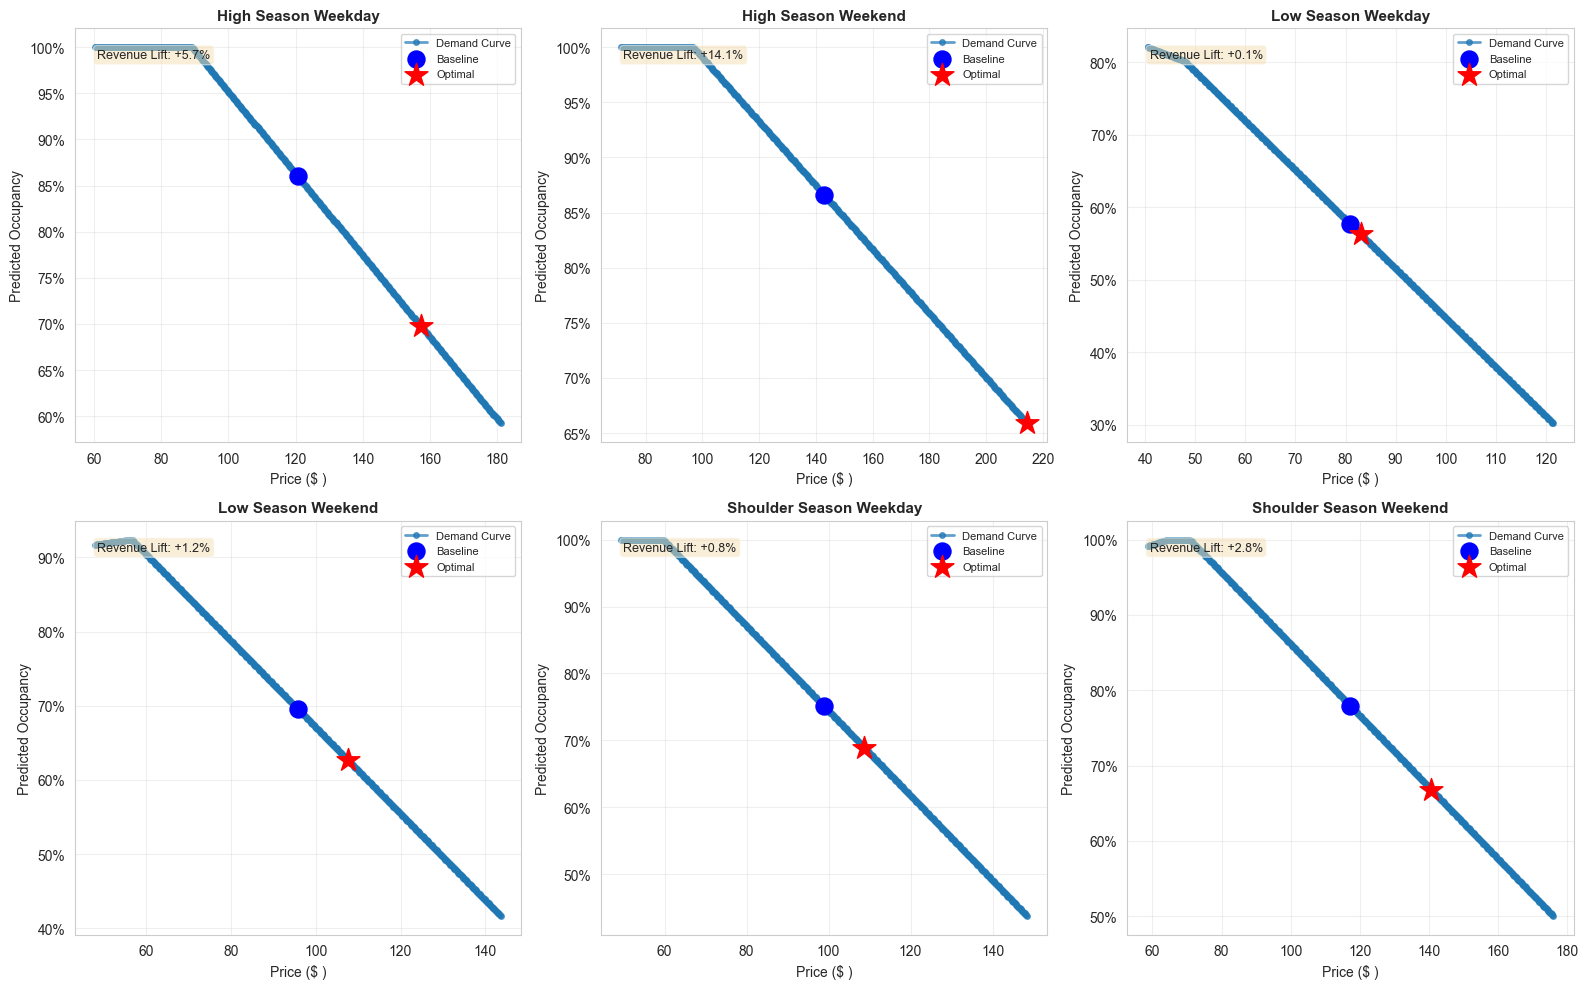

Saved: outputs/optimum_prices_demand_curves_by_segment.png


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

if status == pulp.LpStatusOptimal:
    # ============================================================================
    # PRICE-OCCUPANCY DEMAND CURVES
    # ============================================================================
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, segment_name in enumerate(sorted(candidates_df['segment_name'].unique())):
        ax = axes[idx]
        
        # Get data for this segment
        segment_data = candidates_df[candidates_df['segment_name'] == segment_name]
        optimal_row = optimal_df[optimal_df['segment_name'] == segment_name].iloc[0]
        baseline_row = baseline_df[baseline_df['segment_name'] == segment_name].iloc[0]
        
        # Plot demand curve
        ax.plot(segment_data['price'], segment_data['predicted_occupancy'], 
                'o-', linewidth=2, markersize=4, alpha=0.7, label='Demand Curve')
        
        # Mark baseline
        ax.scatter([baseline_row['baseline_price']], [baseline_row['baseline_occupancy']], 
                   s=150, c='blue', marker='o', label='Baseline', zorder=5)
        
        # Mark optimal
        ax.scatter([optimal_row['optimal_price']], [optimal_row['predicted_occupancy']], 
                   s=300, c='red', marker='*', label='Optimal', zorder=5)
        
        # Formatting
        ax.set_xlabel('Price ($ )', fontsize=10)
        ax.set_ylabel('Predicted Occupancy', fontsize=10)
        ax.set_title(f'{segment_name.replace("_", " ").title()}', fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
        
        # Add revenue lift annotation
        lift_pct = optimal_row['revenue_lift_pct']
        ax.text(0.05, 0.95, f'Revenue Lift: {lift_pct:+.1f}%', 
                transform=ax.transAxes, fontsize=9, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(outputs_dir / 'optimum_prices_demand_curves_by_segment.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Saved: outputs/optimum_prices_demand_curves_by_segment.png")

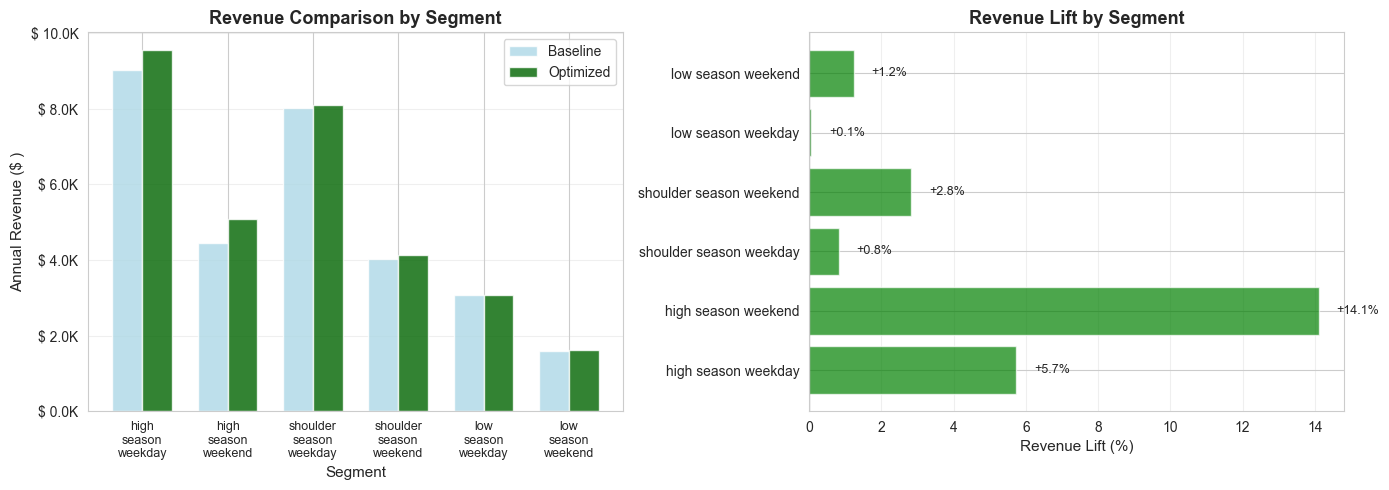

Saved: outputs/revenue_comparison.png


In [47]:
if status == pulp.LpStatusOptimal:
    # ============================================================================
    # REVENUE LIFT COMPARISON
    # ============================================================================
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Revenue comparison
    x_pos = range(len(optimal_df))
    width = 0.35
    
    ax1.bar([x - width/2 for x in x_pos], optimal_df['baseline_annual_revenue'], 
            width, label='Baseline', color='lightblue', alpha=0.8)
    ax1.bar([x + width/2 for x in x_pos], optimal_df['annual_revenue'], 
            width, label='Optimized', color='darkgreen', alpha=0.8)
    
    ax1.set_xlabel('Segment', fontsize=11)
    ax1.set_ylabel('Annual Revenue ($ )', fontsize=11)
    ax1.set_title('Revenue Comparison by Segment', fontsize=13, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([s.replace('_', '\n') for s in optimal_df['segment_name']], 
                         fontsize=9, rotation=0)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'$ {x/1000:.1f}K'))
    
    # Revenue lift percentage
    colors = ['green' if x > 0 else 'red' for x in optimal_df['revenue_lift_pct']]
    ax2.barh(range(len(optimal_df)), optimal_df['revenue_lift_pct'], color=colors, alpha=0.7)
    ax2.set_yticks(range(len(optimal_df)))
    ax2.set_yticklabels([s.replace('_', ' ') for s in optimal_df['segment_name']], fontsize=10)
    ax2.set_xlabel('Revenue Lift (%)', fontsize=11)
    ax2.set_title('Revenue Lift by Segment', fontsize=13, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, v in enumerate(optimal_df['revenue_lift_pct']):
        ax2.text(v + 0.5, i, f'{v:+.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(outputs_dir / 'revenue_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Saved: outputs/revenue_comparison.png")

## Export Results & Business Recommendations

In [48]:
if status == pulp.LpStatusOptimal:
    # ============================================================================
    # EXPORT OPTIMAL PRICING SCHEDULE
    # ============================================================================
    
    export_df = optimal_df[[
        'segment_name', 'season', 'weekend',
        'baseline_price', 'optimal_price', 'price_change_pct',
        'baseline_occupancy', 'predicted_occupancy', 'occupancy_change_pct',
        'baseline_annual_revenue', 'annual_revenue', 'revenue_lift', 'revenue_lift_pct',
        'days_in_segment', 'elasticity_slope'
    ]].copy()
    
    # Round for readability
    export_df = export_df.round({
        'baseline_price': 2,
        'optimal_price': 2,
        'price_change_pct': 1,
        'baseline_occupancy': 4,
        'predicted_occupancy': 4,
        'occupancy_change_pct': 1,
        'baseline_annual_revenue': 2,
        'annual_revenue': 2,
        'revenue_lift': 2,
        'revenue_lift_pct': 1,
        'elasticity_slope': 3
    })
    
    # Save to CSV
    export_path = outputs_dir / 'optimal_prices_paris.csv'
    export_df.to_csv(export_path, index=False)
    print(f"Saved optimal pricing schedule: outputs/optimal_prices_paris.csv\n")
    
    # ============================================================================
    # EXPORT BUSINESS SUMMARY (JSON)
    # ============================================================================
    
    business_summary = {
        'optimization_date': pd.Timestamp.now().isoformat(),
        'target_city': TARGET_CITY,
        'property_profile': {
            'capacity': int(base_property['person_capacity']),
            'bedrooms': int(base_property['bedrooms']),
            'cleanliness_rating': float(base_property['cleanliness_rating']),
            'guest_satisfaction': float(base_property['guest_satisfaction_overall']),
            'room_type': 'Entire Home/Apt',
            'superhost': bool(base_property['host_is_superhost'])
        },
        'baseline_performance': {
            'annual_revenue': float(optimal_df['baseline_annual_revenue'].sum()),
            'weighted_avg_price': float((optimal_df['baseline_price'] * optimal_df['days_in_segment']).sum() / optimal_df['days_in_segment'].sum()),
            'avg_occupancy': float(optimal_df['baseline_occupancy'].mean())
        },
        'optimized_performance': {
            'annual_revenue': float(optimal_df['annual_revenue'].sum()),
            'weighted_avg_price': float((optimal_df['optimal_price'] * optimal_df['days_in_segment']).sum() / optimal_df['days_in_segment'].sum()),
            'avg_occupancy': float(optimal_df['predicted_occupancy'].mean())
        },
        'revenue_lift': {
            'absolute_eur': float(optimal_df['revenue_lift'].sum()),
            'percentage': float(optimal_df['revenue_lift'].sum() / optimal_df['baseline_annual_revenue'].sum() * 100)
        },
        'optimization_constraints': {
            'price_range_tested': f'±{PRICE_RANGE_PCT:.0%}',
            'min_occupancy_threshold': f'{MIN_OCCUPANCY:.0%}',
            'weekend_premium': f'{WEEKEND_PREMIUM:.0%}',
            'portfolio_price_change_limit': f'±{MAX_PRICE_CHANGE:.0%}'
        },
        'pricing_recommendations': [
            {
                'segment': row['segment_name'],
                'recommended_price': float(row['optimal_price']),
                'price_change_vs_baseline': f"{row['price_change_pct']:+.1f}%",
                'expected_occupancy': f"{row['predicted_occupancy']:.1%}",
                'expected_revenue_lift': f"{row['revenue_lift_pct']:+.1f}%"
            }
            for _, row in optimal_df.iterrows()
        ],
        'key_insights': [
            f"Optimal annual revenue of $ {optimal_df['annual_revenue'].sum():,.2f} represents a {optimal_df['revenue_lift'].sum() / optimal_df['baseline_annual_revenue'].sum() * 100:+.1f}% improvement over baseline",
            f"Highest revenue lift achieved in {optimal_df.loc[optimal_df['revenue_lift_pct'].idxmax(), 'segment_name']} segment ({optimal_df['revenue_lift_pct'].max():+.1f}%)",
            f"Weekend pricing averages $ {optimal_df[optimal_df['weekend']==1]['optimal_price'].mean():.2f}, {(optimal_df[optimal_df['weekend']==1]['optimal_price'].mean() / optimal_df[optimal_df['weekend']==0]['optimal_price'].mean() - 1) * 100:.1f}% above weekday",
            f"All segments maintain occupancy above {MIN_OCCUPANCY:.0%} threshold",
            "Dynamic pricing strategy balances price increases with demand elasticity to maximize total revenue"
        ]
    }
    
    summary_path = outputs_dir / 'price_optimization_summary.json'
    with open(summary_path, 'w', encoding='utf-8') as f:
        json.dump(business_summary, f, indent=2)
    
    print(f"Saved business summary: outputs/price_optimization_summary.json")
    
    # ============================================================================
    # PRINT KEY BUSINESS RECOMMENDATIONS
    # ============================================================================
    
    print("\n" + "="*70)
    print("KEY BUSINESS INSIGHTS & RECOMMENDATIONS")
    print("="*70)
    print()
    for i, insight in enumerate(business_summary['key_insights'], 1):
        print(f"{i}. {insight}")
    
    print("="*70)
    print("OPTIMIZATION COMPLETE - All outputs saved to outputs/ directory")
    print("="*70)
else:
    print("\nOptimization failed - no results to export")

Saved optimal pricing schedule: outputs/optimal_prices_paris.csv

Saved business summary: outputs/price_optimization_summary.json

KEY BUSINESS INSIGHTS & RECOMMENDATIONS

1. Optimal annual revenue of $ 31,560.50 represents a +4.5% improvement over baseline
2. Highest revenue lift achieved in high_season_weekend segment (+14.1%)
3. Weekend pricing averages $ 154.23, 32.5% above weekday
4. All segments maintain occupancy above 50% threshold
5. Dynamic pricing strategy balances price increases with demand elasticity to maximize total revenue
OPTIMIZATION COMPLETE - All outputs saved to outputs/ directory


In [49]:
print("\n" + "="*70)
print("IMPLEMENTATION ROADMAP")
print("="*70)
print("""
If method was applied at scale to multiple properties, consider a phased rollout:

1. PHASE 1 - VALIDATION (2 weeks)
    • Test optimal prices on 20% of listings
    • Monitor occupancy and revenue metrics daily
    • A/B test against baseline pricing

2. PHASE 2 - ROLLOUT (4 weeks)
    • Gradually expand to 50% of portfolio
    • Segment-by-segment implementation
    • Real-time performance tracking

3. PHASE 3 - OPTIMIZATION (Ongoing)
    • Monthly model retraining with new data
    • Seasonal pattern adjustments
    • Competitive intelligence integration

4. SUCCESS METRICS
    • Revenue per available night
    • Average daily rate
    • Occupancy rate by segment
    • Guest satisfaction scores
""")


IMPLEMENTATION ROADMAP

If method was applied at scale to multiple properties, consider a phased rollout:

1. PHASE 1 - VALIDATION (2 weeks)
    • Test optimal prices on 20% of listings
    • Monitor occupancy and revenue metrics daily
    • A/B test against baseline pricing

2. PHASE 2 - ROLLOUT (4 weeks)
    • Gradually expand to 50% of portfolio
    • Segment-by-segment implementation
    • Real-time performance tracking

3. PHASE 3 - OPTIMIZATION (Ongoing)
    • Monthly model retraining with new data
    • Seasonal pattern adjustments
    • Competitive intelligence integration

4. SUCCESS METRICS
    • Revenue per available night
    • Average daily rate
    • Occupancy rate by segment
    • Guest satisfaction scores



In [50]:
# Clean up Spark session
spark.stop()
print("Spark session terminated")

Spark session terminated
